# Visualize Amazon Customer Reviews Dataset

# Dataset Column Descriptions

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.

In [1]:
!pip install -q pandas==0.23.0
!pip install -q numpy==1.14.3
!pip install -q matplotlib==3.0.3
!pip install -q seaborn==0.8.1
!pip install -q PyAthena==1.8.0

In [2]:
import boto3
import sagemaker

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
# Get region 
session = boto3.session.Session()
region_name = session.region_name

# Get SageMaker session & default S3 bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

# Set Athena database & table 
database_name = 'dsoaws'
table_name = 'amazon_reviews_parquet'

In [4]:
from pyathena import connect
from pyathena.pandas_cursor import PandasCursor
from pyathena.util import as_pandas

In [5]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = 's3://{0}/athena/staging'.format(bucket)

# Set Seaborn Parameters

In [6]:
sns.set_style = 'seaborn-whitegrid'

sns.set(rc={"font.style":"normal",
            "axes.facecolor":"white",
            'grid.color': '.8',
            'grid.linestyle': '-',
            "figure.facecolor":"white",
            "figure.titlesize":20,
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":True,
            'axes.labelsize':10,
            'figure.figsize':(10.0, 10.0),
            'xtick.labelsize':10,
            'font.size':10,
            'ytick.labelsize':10})

# Helper Code to Display Values on Bars

In [7]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()),2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

# 1. Which Product Categories are Highest Rated by Average Rating?

In [8]:
# SQL statement
statement = """
SELECT product_category, AVG(star_rating) AS avg_star_rating
FROM {}.{} 
GROUP BY product_category 
ORDER BY avg_star_rating DESC
""".format(database_name, table_name)

print(statement)


SELECT product_category, AVG(star_rating) AS avg_star_rating
FROM dsoaws.amazon_reviews_parquet 
GROUP BY product_category 
ORDER BY avg_star_rating DESC



In [9]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,product_category,avg_star_rating
0,Digital_Video_Games,3.853126
1,Digital_Software,3.539330


In [10]:
# Store number of categories
num_categories = df.shape[0]
print(num_categories)

# Store average star ratings
average_star_ratings = df

2


## Visualization for a Subset of Product Categories

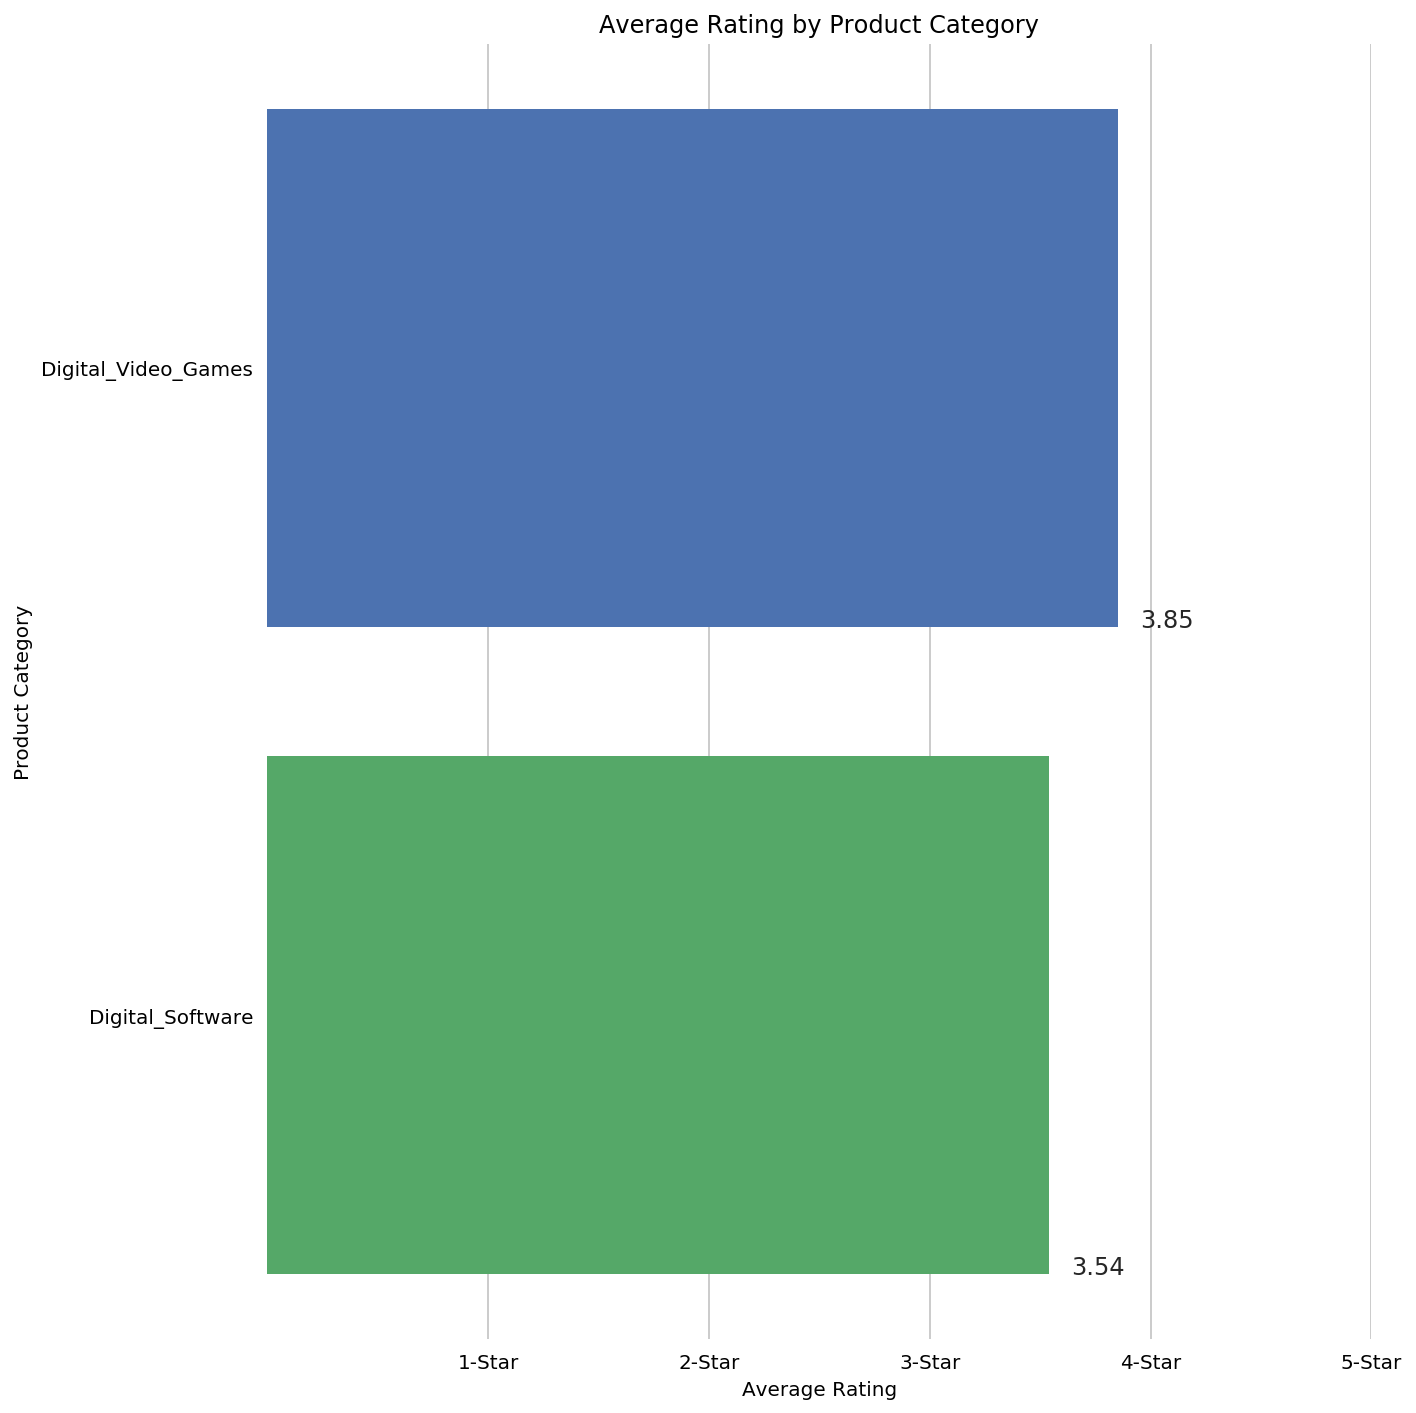

In [11]:
# Create plot
barplot = sns.barplot(y='product_category', x='avg_star_rating', data = df, saturation=1)

if num_categories < 10:
    sns.set(rc={'figure.figsize':(10.0, 5.0)})
    
# Set title and x-axis ticks 
plt.title('Average Rating by Product Category')
plt.xticks([1, 2, 3, 4, 5], ['1-Star', '2-Star', '3-Star','4-Star','5-Star'])

# Helper code to show actual values afters bars 
show_values_barplot(barplot, 0.1)

plt.xlabel("Average Rating")
plt.ylabel("Product Category")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
plt.show(barplot)

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-01.png"  width="80%" align="left">

# 2. Which Product Categories Have the Most Reviews?

In [12]:
# SQL statement
statement = """
SELECT product_category, COUNT(star_rating) AS count_star_rating 
FROM {}.{}
GROUP BY product_category 
ORDER BY count_star_rating DESC
""".format(database_name, table_name)

print(statement)


SELECT product_category, COUNT(star_rating) AS count_star_rating 
FROM dsoaws.amazon_reviews_parquet
GROUP BY product_category 
ORDER BY count_star_rating DESC



In [13]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,product_category,count_star_rating
0,Digital_Video_Games,145431
1,Digital_Software,102084


In [14]:
# Store counts
count_ratings = df['count_star_rating']

# Store max ratings
max_ratings = df['count_star_rating'].max()
print(max_ratings)

145431


## Visualization for a Subset of Product Categories

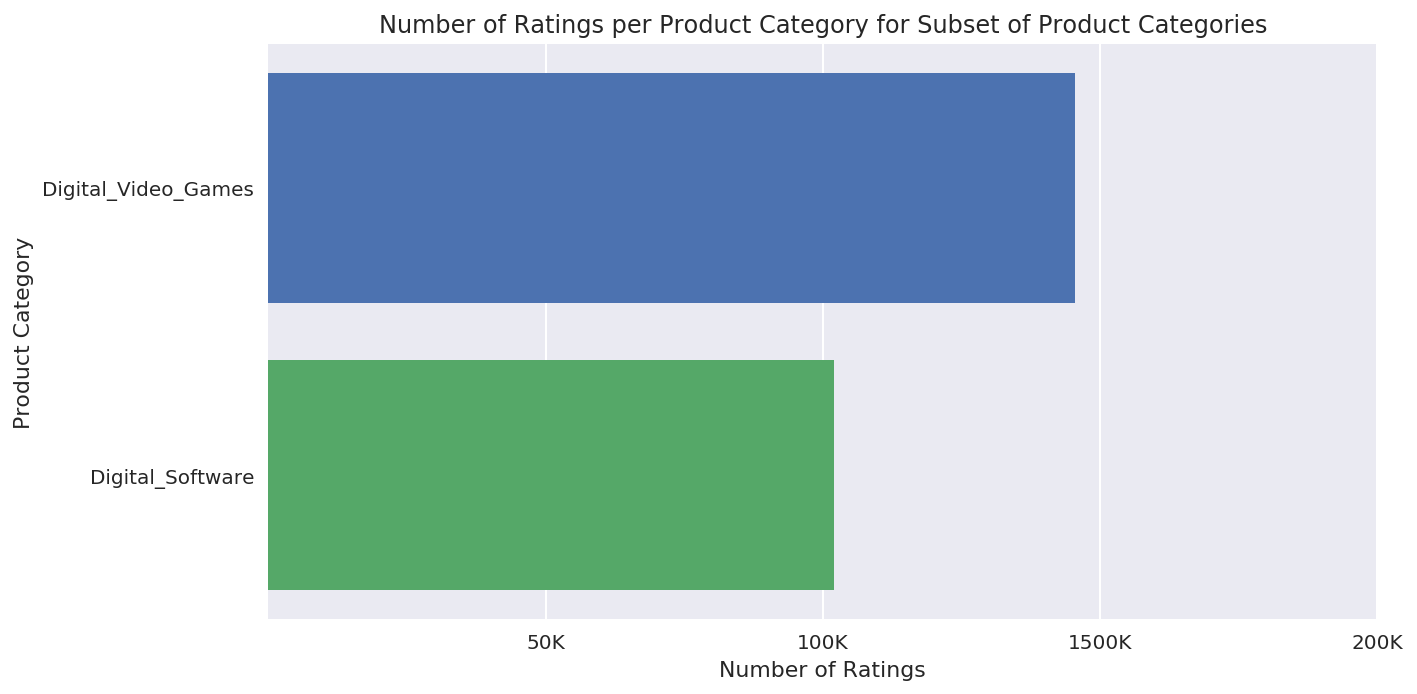

In [15]:
# Create Seaborn barplot
barplot = sns.barplot(y='product_category', x='count_star_rating', data = df, saturation=1)

if num_categories < 10:
    sns.set(rc={'figure.figsize':(10.0, 5.0)})

# Set title
plt.title("Number of Ratings per Product Category for Subset of Product Categories")

# Set x-axis ticks to match scale 
if max_ratings > 200000:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ['100K', '1m', '5m', '10m','15m','20m'])
    plt.xlim(0, 20000000)
elif max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ['50K', '100K', '1500K', '200K'])
    plt.xlim(0, 200000)

plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()

# Export plot if needed
# plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show(barplot)

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-02.png"  width="80%" align="left">

# 3. When did each product category become available in the Amazon catalog based on the date of the first review?

In [16]:
# SQL statement 
statement = """
SELECT product_category, MIN(review_date) AS first_review_date
FROM {}.{}
GROUP BY product_category
ORDER BY first_review_date 
""".format(database_name, table_name)

print(statement)


SELECT product_category, MIN(review_date) AS first_review_date
FROM dsoaws.amazon_reviews_parquet
GROUP BY product_category
ORDER BY first_review_date 



In [17]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,product_category,first_review_date
0,Digital_Video_Games,2006-08-08
1,Digital_Software,2008-01-26


In [18]:
# Convert date strings (e.g. 2014-10-18) to datetime
import datetime as datetime
dates = pd.to_datetime(df['first_review_date'])


In [19]:
# See: https://stackoverflow.com/questions/60761410/how-to-graph-events-on-a-timeline

def modify_dataframe(df):
    """ Modify dataframe to include new columns """
    df['year'] = pd.to_datetime(df['first_review_date'], format='%Y-%m-%d').dt.year
    return df

def get_x_y(df):
    """ Get X and Y coordinates; return tuple """
    series = df['year'].value_counts().sort_index()
    # new_series = series.reindex(range(1,21)).fillna(0).astype(int)
    return series.index, series.values


In [20]:
new_df = modify_dataframe(df)
print(new_df)

X, Y = get_x_y(new_df)

      product_category first_review_date  year
0  Digital_Video_Games        2006-08-08  2006
1     Digital_Software        2008-01-26  2008


## Visualization for a Subset of Product Categories

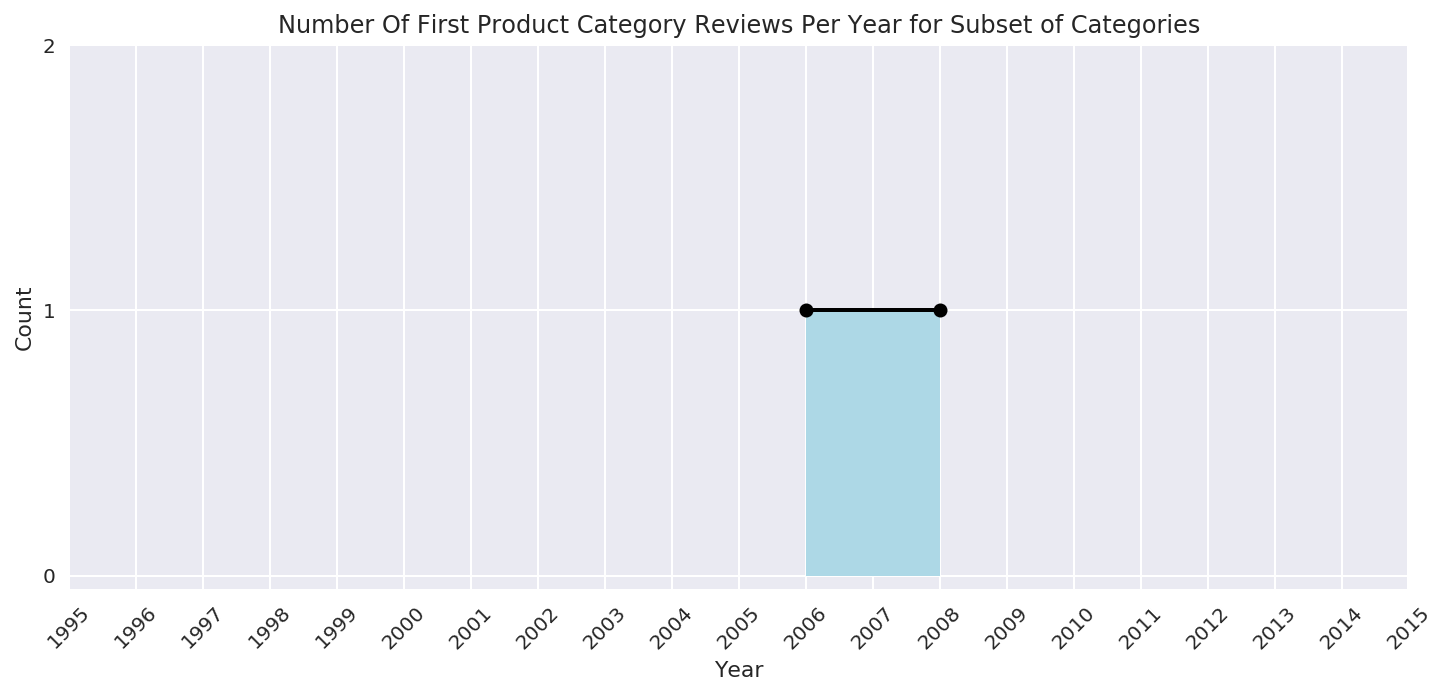

In [21]:
fig = plt.figure(figsize=(12,5))
ax = plt.gca()

ax.set_title('Number Of First Product Category Reviews Per Year for Subset of Categories')
ax.set_xlabel('Year')
ax.set_ylabel('Count')

ax.plot(X, Y, color="black", linewidth=2, marker="o")
ax.fill_between(X, [0]*len(X), Y, facecolor='lightblue')

ax.locator_params(integer=True)

ax.set_xticks(range(1995, 2016, 1))
ax.set_yticks(range(0, max(Y)+2, 1))

plt.xticks(rotation=45)

# fig.savefig('first_reviews_per_year.png', dpi=300)
plt.show()

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-04.png"  width="90%" align="left">

# 4. What is the breakdown of ratings (1-5) per product category?  


In [22]:
# SQL statement 
statement = """
SELECT product_category,
         star_rating,
         COUNT(*) AS count_reviews
FROM {}.{}
GROUP BY  product_category, star_rating
ORDER BY  product_category ASC, star_rating DESC, count_reviews
""".format(database_name, table_name)

print(statement)


SELECT product_category,
         star_rating,
         COUNT(*) AS count_reviews
FROM dsoaws.amazon_reviews_parquet
GROUP BY  product_category, star_rating
ORDER BY  product_category ASC, star_rating DESC, count_reviews



In [23]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,product_category,star_rating,count_reviews
0,Digital_Software,5,46410
1,Digital_Software,4,16693
2,Digital_Software,3,8308
3,Digital_Software,2,6890
4,Digital_Software,1,23783
5,Digital_Video_Games,5,80677
6,Digital_Video_Games,4,20406
7,Digital_Video_Games,3,11629
8,Digital_Video_Games,2,7749
9,Digital_Video_Games,1,24970


## Prepare for Stacked Percentage Horizontal Bar Plot Showing Proportion of Star Ratings per Product Category

In [24]:
# Create grouped DataFrames by category and by star rating
grouped_category = df.groupby('product_category')
grouped_star = df.groupby('star_rating')

# Create sum of ratings per star rating
df_sum = df.groupby(['star_rating']).sum()

# Calculate total number of star ratings
total = df_sum['count_reviews'].sum()
print(total)

247515


In [25]:
# Create dictionary of product categories and array of star rating distribution per category
distribution = {}
count_reviews_per_star = []
i=0
    
for category, ratings in grouped_category:
    count_reviews_per_star = []
    for star in ratings['star_rating']:
        count_reviews_per_star.append(ratings.get_value(i, 'count_reviews'))
        i=i+1;
    distribution[category] = count_reviews_per_star

# Check if distribution has been created succesfully
print(distribution)


{'Digital_Software': [46410, 16693, 8308, 6890, 23783], 'Digital_Video_Games': [80677, 20406, 11629, 7749, 24970]}


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [26]:
# Check if distribution keys are set correctly to product categories
print(distribution.keys())

dict_keys(['Digital_Software', 'Digital_Video_Games'])


In [27]:
# Check if star rating distributions are set correctly
print(distribution.items())

dict_items([('Digital_Software', [46410, 16693, 8308, 6890, 23783]), ('Digital_Video_Games', [80677, 20406, 11629, 7749, 24970])])


### Build Array per Star Across All Categories

In [28]:
# Sort distribution by highest average rating per category
sorted_distribution = {}

average_star_ratings.iloc[:,0]
for index, value in average_star_ratings.iloc[:,0].items():
    sorted_distribution[value] = distribution[value]

In [29]:
sorted_distribution

{'Digital_Video_Games': [80677, 20406, 11629, 7749, 24970],
 'Digital_Software': [46410, 16693, 8308, 6890, 23783]}

In [30]:
# Build array per star across all categories
star1 = []
star2 = []
star3 = []
star4 = []
star5 = []

for k in sorted_distribution.keys():
    stars = sorted_distribution.get(k)
    star5.append(stars[0])
    star4.append(stars[1])
    star3.append(stars[2])
    star2.append(stars[3])
    star1.append(stars[4])

## Visualization for a Subset of Product Categories

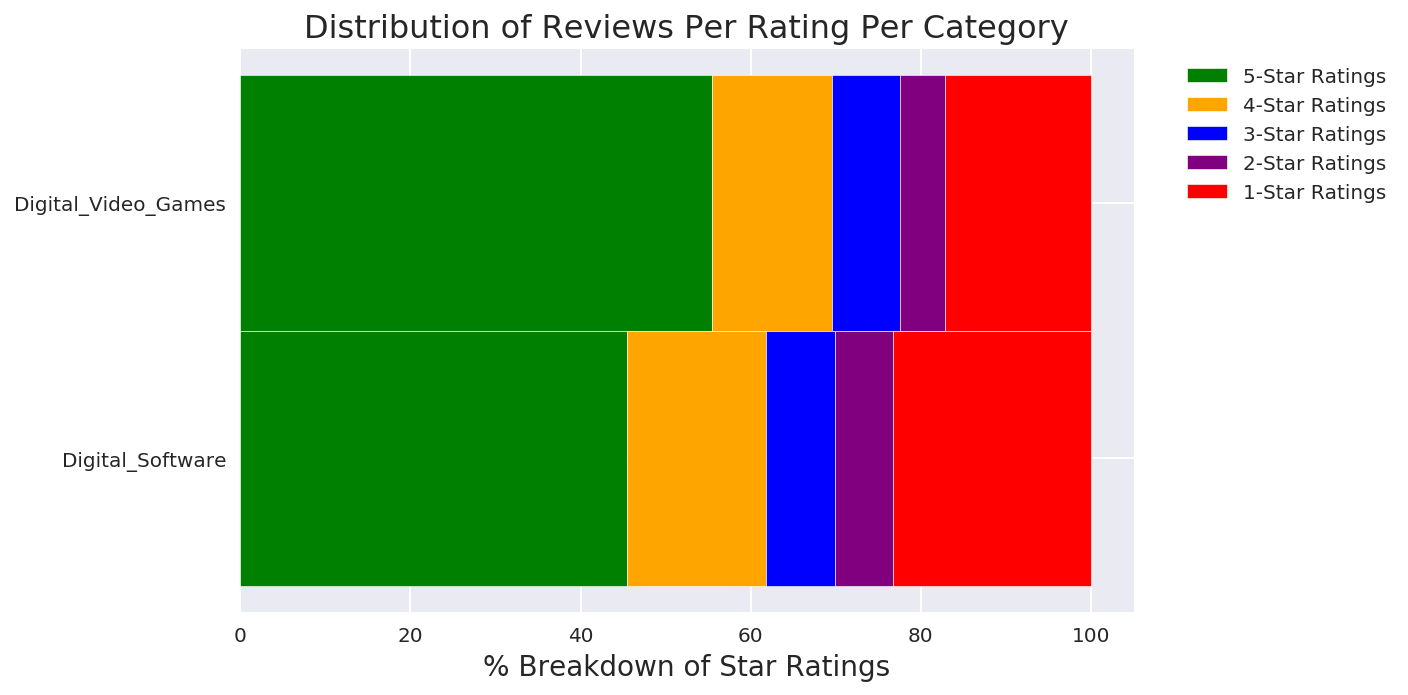

In [31]:
# Plot the distributions of star ratings per product category

categories = sorted_distribution.keys()

total = np.array(star1) + np.array(star2) + np.array(star3) + np.array(star4) + np.array(star5)

proportion_star1 = np.true_divide(star1, total) * 100
proportion_star2 = np.true_divide(star2, total) * 100
proportion_star3 = np.true_divide(star3, total) * 100
proportion_star4 = np.true_divide(star4, total) * 100
proportion_star5 = np.true_divide(star5, total) * 100

# Add colors
colors = ['red', 'purple','blue','orange','green']

# The position of the bars on the x-axis
r = range(len(categories))
barHeight = 1

# Plot bars
if num_categories > 10:
    plt.figure(figsize=(10,10))
else: 
    plt.figure(figsize=(10,5))

ax5 = plt.barh(r, proportion_star5, color=colors[4], edgecolor='white', height=barHeight, label='5-Star Ratings')
ax4 = plt.barh(r, proportion_star4, left=proportion_star5, color=colors[3], edgecolor='white', height=barHeight, label='4-Star Ratings')
ax3 = plt.barh(r, proportion_star3, left=proportion_star5+proportion_star4, color=colors[2], edgecolor='white', height=barHeight, label='3-Star Ratings')
ax2 = plt.barh(r, proportion_star2, left=proportion_star5+proportion_star4+proportion_star3, color=colors[1], edgecolor='white', height=barHeight, label='2-Star Ratings')
ax1 = plt.barh(r, proportion_star1, left=proportion_star5+proportion_star4+proportion_star3+proportion_star2, color=colors[0], edgecolor='white', height=barHeight, label="1-Star Ratings")

plt.title("Distribution of Reviews Per Rating Per Category",fontsize='16')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.yticks(r, categories, fontweight='regular')

plt.xlabel("% Breakdown of Star Ratings", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()

# plt.savefig('proportion_star_per_category.png', dpi=300)
plt.show()

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-05.png"  width="80%" align="left">

# 5. How Many Reviews per Star Rating? (5, 4, 3, 2, 1) 

In [32]:
# SQL statement 
statement = """
SELECT star_rating,
         COUNT(*) AS count_reviews
FROM dsoaws.amazon_reviews_parquet
GROUP BY  star_rating
ORDER BY  star_rating DESC, count_reviews 
""".format(database_name, table_name)

print(statement)


SELECT star_rating,
         COUNT(*) AS count_reviews
FROM dsoaws.amazon_reviews_parquet
GROUP BY  star_rating
ORDER BY  star_rating DESC, count_reviews 



In [33]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,star_rating,count_reviews
0,5,127087
1,4,37099
2,3,19937
3,2,14639
4,1,48753


## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:

<img src="img/star_rating_count_all.png"  width="25%" align="left">

# 6. How Did Star Ratings Change Over Time?
Is there a drop-off point for certain product categories throughout the year?

## Average Star Rating Across All Product Categories

In [34]:
# SQL statement 
statement = """
SELECT year, ROUND(AVG(star_rating),4) AS avg_rating
FROM {}.{}
GROUP BY year
ORDER BY year
""".format(database_name, table_name)

print(statement)


SELECT year, ROUND(AVG(star_rating),4) AS avg_rating
FROM dsoaws.amazon_reviews_parquet
GROUP BY year
ORDER BY year



In [35]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,year,avg_rating
0,2006,4.0000
1,2008,2.6286
2,2009,3.7140
3,2010,3.5550
4,2011,3.6062
5,2012,3.6099
6,2013,3.6437
7,2014,3.8842
8,2015,3.6710


In [36]:
df['year'] = pd.to_datetime(df['year'], format='%Y').dt.year


## Visualization for a Subset of Product Categories

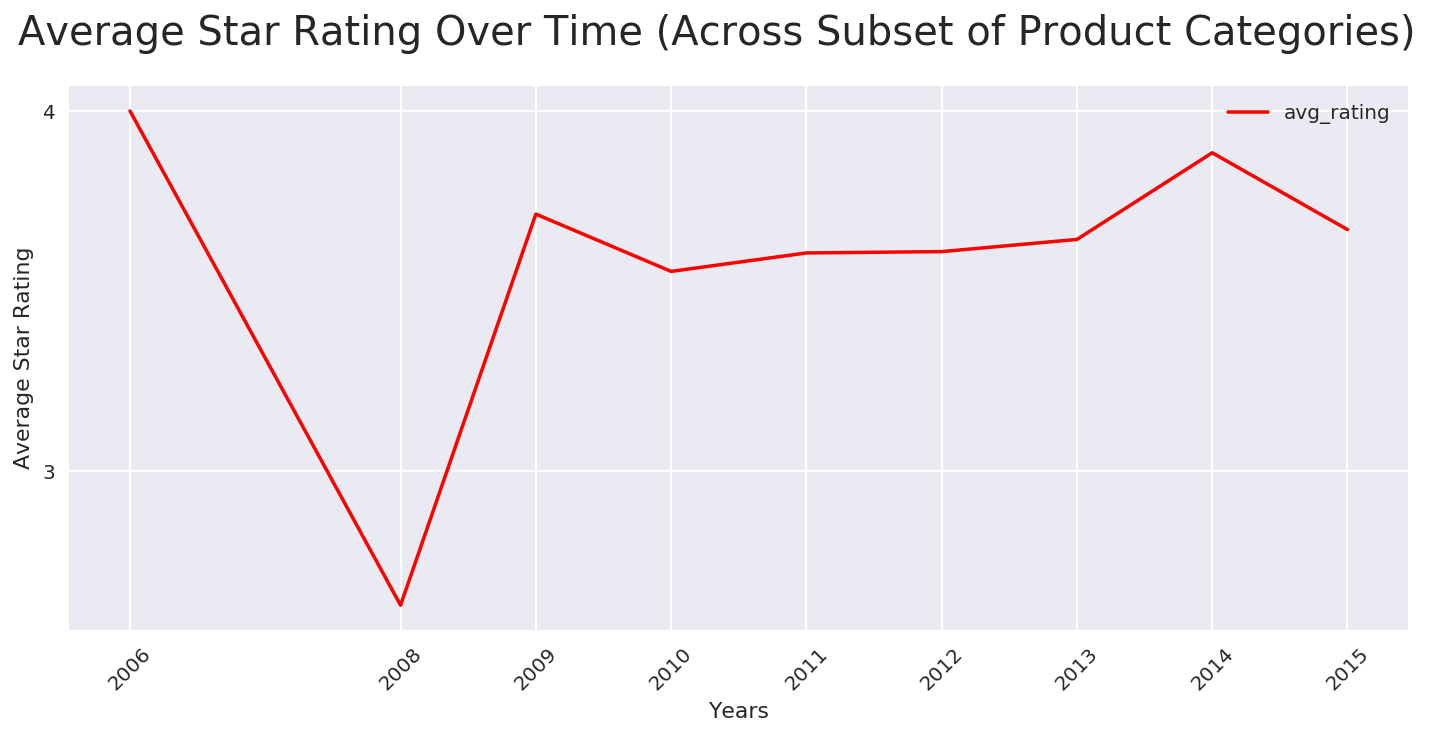

In [37]:
fig = plt.gcf()
fig.set_size_inches(12,5)

fig.suptitle('Average Star Rating Over Time (Across Subset of Product Categories)')

ax = plt.gca()
#ax = plt.gca().set_xticks(df['year'])
ax.locator_params(integer=True)
ax.set_xticks(df['year'].unique())

df.plot(kind='line',x='year',y='avg_rating', color='red', ax=ax)

#plt.xticks(range(1995, 2016, 1))
#plt.yticks(range(0,6,1))
plt.xlabel('Years')
plt.ylabel('Average Star Rating')
plt.xticks(rotation=45)

# fig.savefig('average-rating.png', dpi=300)
plt.show()

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-06.png"  width="90%" align="left">

## Average Star Rating Per Product Categories Across Time

In [38]:
# SQL statement 
statement = """
SELECT product_category, year, ROUND(AVG(star_rating), 4) AS avg_rating_category
FROM {}.{}
GROUP BY product_category, year
ORDER BY year 
""".format(database_name, table_name)

print(statement)


SELECT product_category, year, ROUND(AVG(star_rating), 4) AS avg_rating_category
FROM dsoaws.amazon_reviews_parquet
GROUP BY product_category, year
ORDER BY year 



In [39]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,product_category,year,avg_rating_category
0,Digital_Video_Games,2006,4.0000
1,Digital_Video_Games,2008,2.0000
2,Digital_Software,2008,2.7333
3,Digital_Software,2009,2.7603
4,Digital_Video_Games,2009,3.8924
5,Digital_Video_Games,2010,3.7338
6,Digital_Software,2010,3.1268
7,Digital_Software,2011,3.4667
8,Digital_Video_Games,2011,3.6484
9,Digital_Software,2012,3.3902


## Visualization

In [40]:
def plot_categories(df):
    df_categories = df['product_category'].unique()
    for category in df_categories:
        # print(category)
        df_plot = df.loc[df['product_category'] == category]
        df_plot.plot(kind='line',x='year',y='avg_rating_category', c=np.random.rand(3,), ax=ax, label=category)

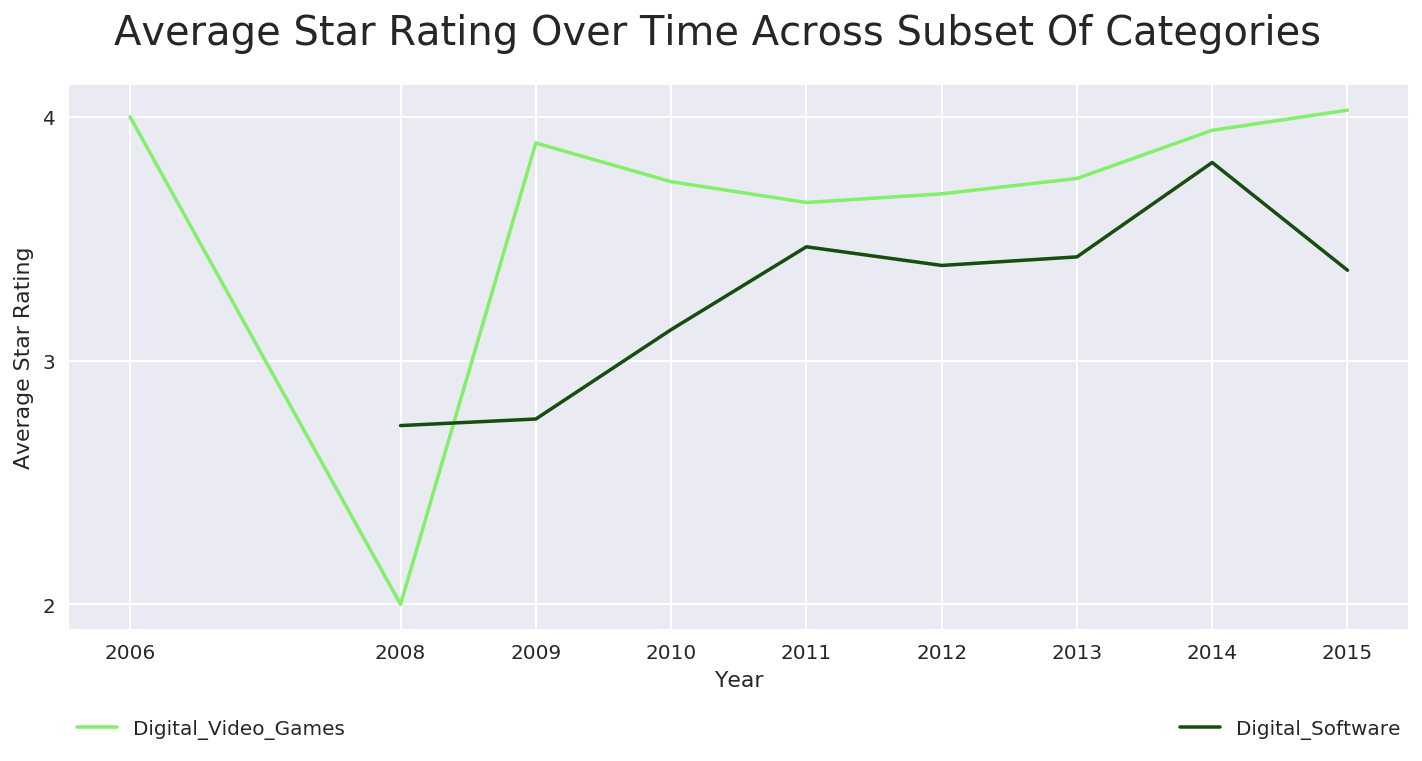

In [41]:
fig = plt.gcf()
fig.set_size_inches(12,5)

fig.suptitle('Average Star Rating Over Time Across Subset Of Categories')
           
ax = plt.gca()

ax.locator_params(integer=True)
ax.set_xticks(df['year'].unique())

plot_categories(df)

plt.xlabel('Year')
plt.ylabel('Average Star Rating')
plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)

# fig.savefig('average_rating_category_all_data.png', dpi=300)
plt.show()

## Visualization for All Product Categories
If you ran this same query across all product categories, you would see the following visualization:

<img src="img/average_rating_category_all_data.png"  width="90%" align="left">

# 7. Which Star Ratings (1-5) are Most Helpful?

In [42]:
# SQL statement 
statement = """
SELECT star_rating,
         AVG(helpful_votes) AS avg_helpful_votes
FROM {}.{}
GROUP BY  star_rating
ORDER BY  star_rating ASC
""".format(database_name, table_name)

print(statement)


SELECT star_rating,
         AVG(helpful_votes) AS avg_helpful_votes
FROM dsoaws.amazon_reviews_parquet
GROUP BY  star_rating
ORDER BY  star_rating ASC



In [43]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df

,star_rating,avg_helpful_votes
0,1,4.748118
1,2,2.291072
2,3,1.635652
3,4,1.245802
4,5,0.962750


## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:

<img src="img/star_rating_helpful_all.png"  width="25%" align="left">

## Visualization for a Subset of Product Categories

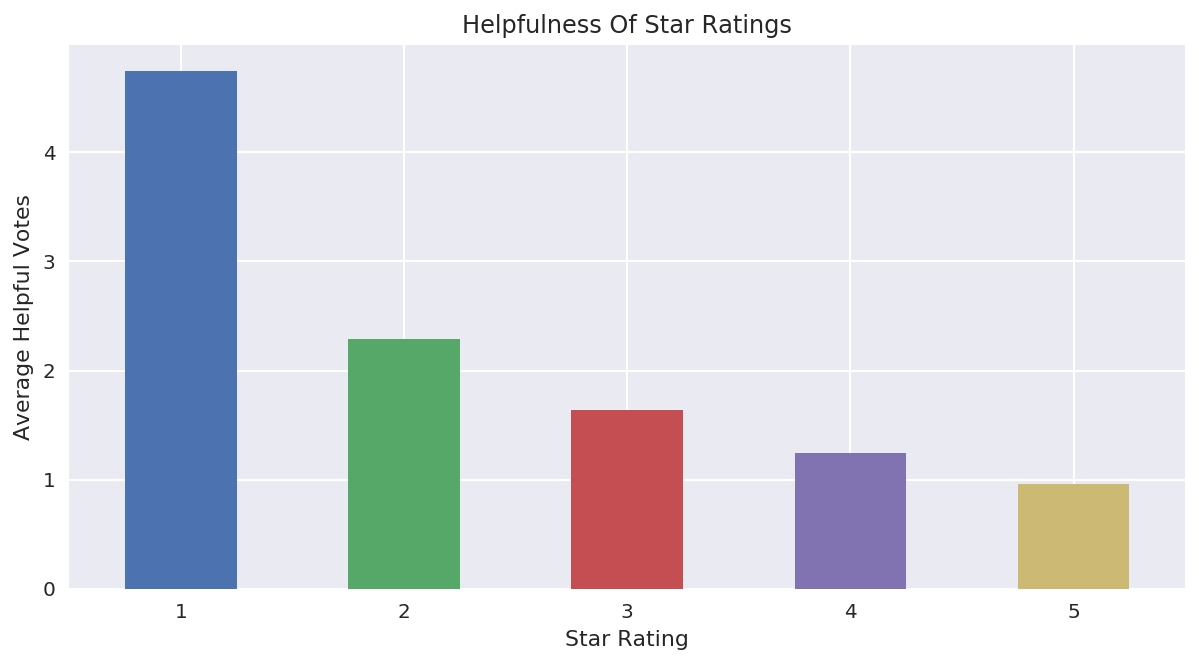

In [44]:
chart = df.plot.bar(x='star_rating', y='avg_helpful_votes', rot='0', figsize=(10,5), title='Helpfulness Of Star Ratings', legend=False )

plt.xlabel('Star Rating')
plt.ylabel('Average Helpful Votes')

# chart.get_figure().savefig('helpful-votes.png', dpi=300)
plt.show(chart)

## Visualization for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following visualization:

<img src="img/c4-08.png"  width="70%" align="left">

# 8. Which Products have Most Helpful Reviews?  How Long are the Most Helpful Reviews?

In [45]:
# SQL statement 
statement = """
SELECT product_title,
         helpful_votes,
         star_rating,
         LENGTH(review_body) AS review_body_length,
         SUBSTR(review_body, 1, 100) AS review_body_substr
FROM {}.{}
ORDER BY helpful_votes DESC LIMIT 10 
""".format(database_name, table_name)

print(statement)


SELECT product_title,
         helpful_votes,
         star_rating,
         LENGTH(review_body) AS review_body_length,
         SUBSTR(review_body, 1, 100) AS review_body_substr
FROM dsoaws.amazon_reviews_parquet
ORDER BY helpful_votes DESC LIMIT 10 



In [46]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df.head()

,product_title,helpful_votes,star_rating,review_body_length,review_body_substr
0,TurboTax Deluxe Fed + Efile + State,5363,1,3696,I have been a loyal TurboTax customer since so...
1,SimCity - Limited Edition,5068,1,2478,Guess what? If you'd love to experience the no...
2,SimCity - Limited Edition,3789,1,1423,How would you feel if you waited for the new C...
3,Microsoft Office Home and Student 2013 (1PC/1U...,2955,1,4932,"I have never been a Microsoft hater, as many a..."
4,SimCity - Limited Edition,2509,5,1171,You'd think I'd be mega unhappy like everyone ...


## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:

<img src="img/most_helpful_all.png"  width="90%" align="left">

# 9. What is the Ratio of Positive (5, 4) to Negative (3, 2 ,1) Reviews?

In [47]:
# SQL statement 
statement = """
SELECT (CAST(positive_review_count AS DOUBLE) / CAST(negative_review_count AS DOUBLE)) AS positive_to_negative_sentiment_ratio
FROM (
  SELECT count(*) AS positive_review_count
  FROM {}.{}
  WHERE star_rating >= 4
), (
  SELECT count(*) AS negative_review_count
  FROM {}.{}
  WHERE star_rating < 4
)
""".format(database_name, table_name, database_name, table_name)

print(statement)


SELECT (CAST(positive_review_count AS DOUBLE) / CAST(negative_review_count AS DOUBLE)) AS positive_to_negative_sentiment_ratio
FROM (
  SELECT count(*) AS positive_review_count
  FROM dsoaws.amazon_reviews_parquet
  WHERE star_rating >= 4
), (
  SELECT count(*) AS negative_review_count
  FROM dsoaws.amazon_reviews_parquet
  WHERE star_rating < 4
)



In [48]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df.head()

,positive_to_negative_sentiment_ratio
0,1.970334


## Results for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:

<img src="img/ratio_all.png"  width="25%" align="left">

# 10. Which Customers are Abusing the Review System by Repeatedly Reviewing the Same Product?  What Was Their Average Star Rating for Each Product?

In [49]:
# SQL statement 
statement = """
SELECT customer_id, product_category, product_title, 
ROUND(AVG(star_rating),4) AS avg_star_rating, COUNT(*) AS review_count 
FROM dsoaws.amazon_reviews_parquet 
GROUP BY customer_id, product_category, product_title 
HAVING COUNT(*) > 1 
ORDER BY review_count DESC
LIMIT 5
""".format(database_name, table_name)

print(statement)


SELECT customer_id, product_category, product_title, 
ROUND(AVG(star_rating),4) AS avg_star_rating, COUNT(*) AS review_count 
FROM dsoaws.amazon_reviews_parquet 
GROUP BY customer_id, product_category, product_title 
HAVING COUNT(*) > 1 
ORDER BY review_count DESC
LIMIT 5



In [50]:
cursor = connect(region_name=region_name, s3_staging_dir=s3_staging_dir).cursor()
cursor.execute(statement)

# Load query results into Pandas DataFrame and show results
df = as_pandas(cursor)
df.head()

,customer_id,product_category,product_title,avg_star_rating,review_count
0,31012456,Digital_Video_Games,Call of Duty: Black Ops II - Personalization DLC,5.00,10
1,11421705,Digital_Video_Games,BioWare Points,5.00,8
2,23587418,Digital_Video_Games,BioWare Points,5.00,6
3,30754148,Digital_Video_Games,Sims 4,4.40,5
4,34623838,Digital_Video_Games,Need For Speed World Starter Packs,2.75,4


## Result for All Product Categories
If you ran this same query across all product categories (150+ million reviews), you would see the following result:
  
<img src="img/athena-abuse-all.png"  width="80%" align="left">